<h1>Notes on Linear Regression</h1>
<h2>Matthew P. Jones, Ph.D.</h2>
<h3>A Brief History</h3>

<p>Linear regression is a powerful tool used in supervised machine learning. Here is a brief history of its origin (<i>sourced from Gemini</i>):</p>

<p> Linear regression, a powerful statistical tool for understanding relationships between variables, has a rich history dating back to the late 18th and early 19th centuries. Early forms were used in fields like astronomy and geodesy, with individuals like Newton and Gauss making significant contributions. The term "regression" itself was coined by Francis Galton in the late 19th century, while studying heredity and biological phenomena. </p> 
    
<h4>Key Developments and Influential Figures:</h4>

<h5>Isaac Newton (1700):</h5>
<p>Newton's work on equinoxes demonstrated an early form of linear regression, including averaging data and forcing the regression line to pass through the average point.</p>

<h5>Adrien-Marie Legendre and Carl Friedrich Gauss (1805, 1809):</h5>
<p>Both Legendre and Gauss independently developed and applied the method of least squares to determine the orbits of celestial bodies, a crucial step in the development of linear regression.</p>

<h5>Francis Galton (1886):</h5>
<p>Galton coined the term "regression" to describe his observations that offspring of parents with extreme traits tended to be less extreme, a concept known as "regression to the mean".</p>

<h5>Karl Pearson (1896):</h5>
<p>Pearson provided a rigorous mathematical foundation for correlation and regression, establishing a more formal approach to the field.</p>

<h5>Joseph Berkson (1944):</h5>
<p>Berkson published logistic regression, one of the first classification algorithms, expanding the range of regression models.</p>

<h5>From Biological Origins to Diverse Applications:</h5>
<p>Galton's initial work on heredity and biological phenomena laid the groundwork for understanding relationships between variables. However, linear regression quickly found applications in various fields, including: </p>
<ol>
    <li><b>Astronomy and Geodesy</b>: The method of least squares, developed by Legendre and Gauss, was essential for determining celestial orbits. </li>
    <li><b>Social Sciences</b>: Regression analysis became a valuable tool for analyzing relationships between social and psychological variables.</li>
    <li><b>Machine Learning</b>:Linear regression is a fundamental algorithm in machine learning, used for prediction and classification tasks. </li>
    <li><b>Modern Relevance</b>:
Linear regression remains a crucial statistical tool in various disciplines due to its simplicity, interpretability, and efficiency. While more complex models exist for tackling complex problems, linear regression serves as a foundational technique for predictive modeling and understanding relationships between variables.</li>
    </ol>
<h3>Mathematical Introduction</h3>
<p>Now that we have a solid appreciation for the giants on whomst shoulders we stand, let's move on to a derivation of linear regression (least squares) and begin to visualize how it works...</p>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import tarfile
from six.moves import urllib
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH): 
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
        tgz_path = os.path.join(housing_path, "housing.tgz")
        urllib.request.urlretrieve(housing_url, tgz_path)
        housing_tgz = tarfile.open(tgz_path)
        housing_tgz.extractall(path=housing_path)
        housing_tgz.close()
        
def load_housing_data(housing_path=HOUSING_PATH): 
    csv_path = os.path.join(housing_path, "housing.csv") 
    return pd.read_csv(csv_path)

<p>Let's fetch some housing data that we believe have parameters that are linearly related:</p>

In [2]:
fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH)
housing = load_housing_data()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


<p>For this excercise, let's only look at the relationship between the median income to the median house value. Since this is a rather large dataset, let's take a small subset at random.</p> 

In [3]:
X = housing['median_income']
y = housing['median_house_value']

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.99, shuffle=False, random_state=42 
)

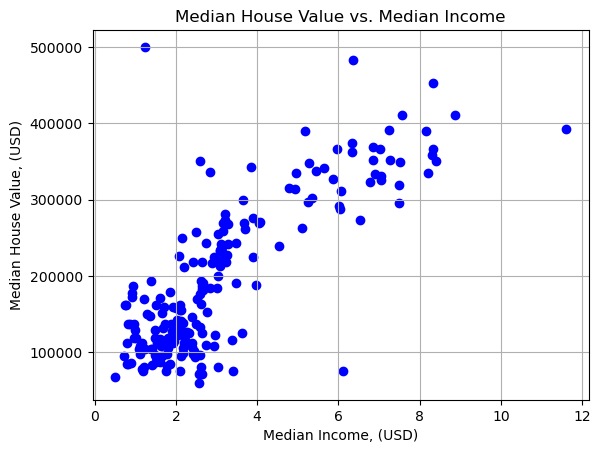

In [4]:
plt.scatter(X_train,y_train, color='blue')
plt.title('Median House Value vs. Median Income')
plt.xlabel('Median Income, (USD)')
plt.ylabel('Median House Value, (USD)')
plt.grid(True)
plt.show()

<p>Great! Our human brains are already able to ``see'' a best-fit line (more or less), but what we want to do is create an iterative process whereby we computationally arrive at an equation that <i>is</i> the best fit line (or if the dataset is very large, an equation that is a good approximation to the best fit line - more on this later).  </p>
<p>Let's start by applying a line made up of the same number of discrete points as we have in our plot.</p>

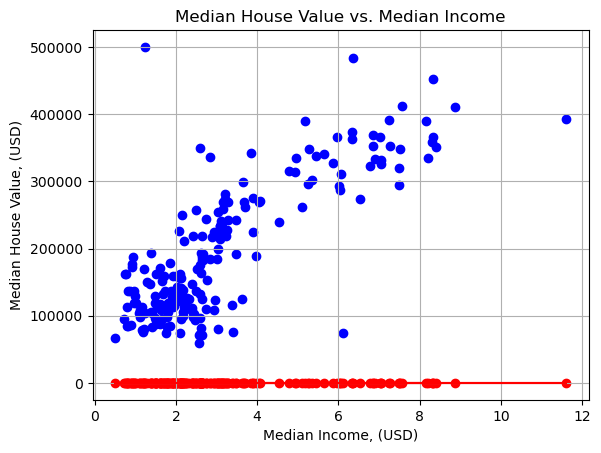

In [5]:
x_fit = X_train
y_fit = np.linspace(0,0,len(y_train))

plt.scatter(X_train,y_train, color='blue')
plt.scatter(x_fit, y_fit, color='red')
plt.plot(x_fit, y_fit, color='red')
plt.title('Median House Value vs. Median Income')
plt.xlabel('Median Income, (USD)')
plt.ylabel('Median House Value, (USD)')
plt.grid(True)
plt.show()

<p>Obviously, the zero-slope line isn't a good fit to our data, but it gives us a way to visualize how we want to steer the line to more closely represent the relationship between median house value and median income. What we seek is a hypothesis equation that is of the $y=mx+b$ form, only written more generally as,

$h_\Theta[x]= \Theta_0+\Theta_1 x$

where the parameters $\Theta_0$ and $\Theta_1$ will be selected through an iterative process. The way we know we are approaching these best-fit parameters is <b>by minimizing the squared difference</b> between $h[x]$ and the $y_{train}$ data points.</p>
    
<p>In other words, we want to choose our $\Theta{j}$ values such that we minimize, $(h[x] - y_{train})^2$</p>

<p>Keep in mind that we want to satisfy this expression for all $206$ datapoints in our subset. So, we really need to minimize the following summed expression that is the Mean Squared Error ``Cost Function'':

$$J[\Theta] = \frac{1}{2m}\sum_{i=1}^{m}{(h_\Theta[x^{i}] - y_{train})^2}$$
    
such that $x_0\equiv 1$.

<b>Note</b>: Don't let the $1/2$ throw you. It is in there for convenience when we take derivatives and doesn't impact our results. After all we are trying to minimize the summation, and half of zero is zero. <p>

<p><b>Note</b>: Later on, we can talk about expanding this concept to include multiple variables (e.g., include number of bedrooms, total rooms, etc. in our analysis). This will ultimately result in a more generalized matrix notation. For now, we will proceed with our simple base-case example.</p>

<p>Our goal now is to iteratively minimize the cost function, $J[\Theta]$ according to an algorithm called ``Gradient Descent.'' While this algorithm is computationally expensive, our modern computers are powerful enough to handle small datasets like this. But I digress...the idea is to begin with a guess for $\Theta_0$ and $\Theta_1$. We have already done this in our earlier plot, $(0,0)$. One can imagine that there is a range of possible values for both $\Theta_0$ and $\Theta_1$ leading to a range of values for $J$. 
    
This can be visualized as a sheet that has been draped over a box (see plot below). The four edges of the box can be curvy, which results in a local minimum. But, if we have a function such that $\nabla^2 J[\Theta] = 0$ (and we always do for linear regression), then the local minimum must be the global minimum! And of course, this is the minimum we are after (i.e., we are trying to minimize the cost function $J[\Theta]$).  </p>

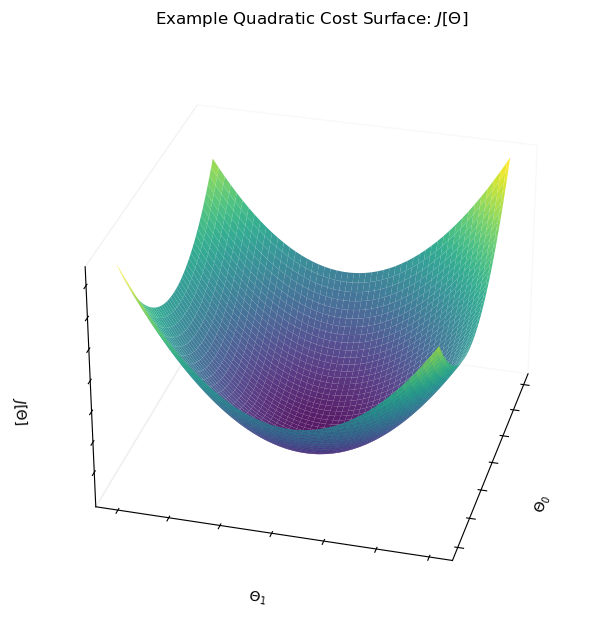

In [6]:
from mpl_toolkits.mplot3d import Axes3D

# Create meshgrid of Theta_0 and Theta_1
theta_0 = np.linspace(-3, 3, 100)
theta_1 = np.linspace(-3, 3, 100)
T0, T1 = np.meshgrid(theta_0, theta_1)

# Random coefficients for a quadratic surface
a = np.random.uniform(0.5, 1.1)
b = np.random.uniform(0.5, 2.0)
c = np.random.uniform(-1.0, 1.0)

# Define cost function J[Theta] as a random quadratic
J = a * T0**2 + b * T1**2 + c * T0 * T1

# Plotting the surface
fig = plt.figure(figsize=(8, 7))
ax = fig.add_subplot(111, projection='3d')

surface = ax.plot_surface(T0, T1, J, cmap='viridis', edgecolor='none', alpha=0.9)

# Labels (LaTeX rendered)
ax.set_xlabel(r'$\Theta_0$', labelpad=10)
ax.set_ylabel(r'$\Theta_1$', labelpad=10)
ax.set_zlabel(r'$J[\Theta]$', labelpad=10)

# Suppress tick labels
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])

# Optional: remove gridlines and panes for cleaner visualization
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
ax.grid(False)

ax.view_init(elev=30, azim=15)  # elev = vertical angle, azim = horizontal rotation


plt.title("Example Quadratic Cost Surface: $J[\\Theta]$", pad=20)
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1)
plt.show()

<p>So let's setup an algorithm that will enable us to pick an initial spot on this surface and incrementally walk down to the global minimum. Keep in mind, as we walk down the sheet, we need to take <i>small</i> steps, otherwise we might overshoot the global minimum and find ourselves oscillating about it forever (i.e., we won't conve3rge on a solution). Let's start by updating $\Theta_j$ as follows:

$$\Theta_j := \Theta_j - \alpha \frac{\partial{J}}{\partial{\Theta_j}}$$

where $\alpha$ is called the <b>learning rate</b> and we are subtracting it from the current $\Theta_j$ becasue we are wanting to ``walk''  downhill. Next, we substitute our cost function into this equation and take the derivative with respect to $\Theta_{j=0}$ and $\Theta_{j=1}$. This results in the following:
    
    
$$\Theta_j := \Theta_j - \alpha \frac{\partial{\left(\frac{1}{2m}\sum_{i=1}^{m}{(h_\Theta[x^{i}] - y_{train})^2}\right)}}{\partial{\Theta_j}}$$



</p>

We can pull the summation (and constant) out of the partial derivative resulting in:

$$\Theta_j := \Theta_j - \alpha \frac{1}{2m}\sum_{i=1}^{m}\frac{\partial{\left({(h_\Theta[x^{i}] - y_{train})^2}\right)}}{\partial{\Theta_j}}$$

Evaluating this by way of the chain rule leads to the following pair of equations that we will iteratively process (recall that $x_0\equiv1$).

$$\Theta_0 := \Theta_0 - \alpha \sum_{i=1}^{m}   (h_\Theta[x^{i}] - y_{train})\cdot{x_0}$$
$$\Theta_1 := \Theta_1 - \alpha \sum_{i=1}^{m}   (h_\Theta[x^{i}] - y_{train})\cdot{x_1}$$

Keep in mind, for Gradient Descent, the summations above must be carried out <b>in full</b> for each iterative step. This is what makes this algorithm computationally expensive for large data sets. A work-around will be provided in a later notebook, but for now, let's proceed by substituting for $h[x]$:

$$\Theta_0 := \Theta_0 - \alpha \sum_{i=1}^{m}   (\Theta_0 + \Theta_1 x^{i} - y_{train})\cdot{x_0^{i}}$$
$$\Theta_1 := \Theta_1 - \alpha \sum_{i=1}^{m}   (\Theta_0 + \Theta_1 x^{i} - y_{train})\cdot{x_1^{i}}$$

Now we are at a point where we can specify $\alpha$. Industry sets it at $0.01$ for normalized data. So let's take this opportunity to create two new columns in our dataframe that represent normalized data.

In [7]:
from sklearn.preprocessing import MinMaxScaler

# Initialize the scaler
scaler = MinMaxScaler()

# Select the original columns
cols_to_scale = ['median_income', 'median_house_value']

# Fit and transform the selected columns
scaled_values = scaler.fit_transform(housing[cols_to_scale])

# Assign to new columns (e.g., add _scaled suffix)
housing[['norm_median_income', 'norm_median_house_value']] = scaled_values

housing[['norm_median_income', 'norm_median_house_value']].head()

,norm_median_income,norm_median_house_value
0,0.539668,0.902266
1,0.538027,0.708247
2,0.466028,0.695051
3,0.354699,0.672783
4,0.230776,0.674638


In [8]:
X = housing['norm_median_income']
y = housing['norm_median_house_value']

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.99, shuffle=False, random_state=42  # don't shuffle time series
)

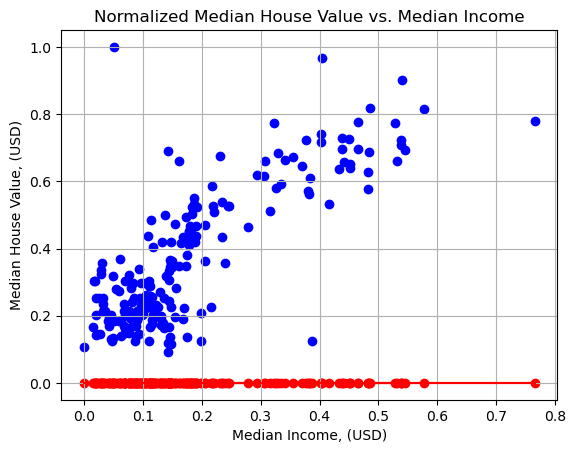

In [9]:
x_fit = X_train
y_fit = np.linspace(0,0,len(y_train))

plt.scatter(X_train,y_train, color='blue')
plt.scatter(x_fit, y_fit, color='red')
plt.plot(x_fit, y_fit, color='red')
plt.title('Normalized Median House Value vs. Median Income')
plt.xlabel('Median Income, (USD)')
plt.ylabel('Median House Value, (USD)')
plt.grid(True)
plt.show()

<h3>Gradient Descent</h3>
The following block of code (if configured correctly) will converge on $\Theta_0$ and $\Theta_1$.

In [10]:
m = len(y_train) #length of subset of data
alpha = 0.05 #learning rate
converge = 1e-6 

theta_0 = 0.0 #initialized
theta_1 = 0.0

loop = True
while loop:
    # Vectorized prediction and error
    preds = theta_0 + theta_1 * X_train
    errors = preds - y_train

    # Compute gradients
    term_0 = np.sum(errors) / m
    term_1 = np.sum(errors * X_train) / m

    # Compute updates
    delta_0 = alpha * term_0
    delta_1 = alpha * term_1

    # Update parameters
    theta_0 -= delta_0
    theta_1 -= delta_1

    # Convergence check
    if np.sqrt(delta_0**2 + delta_1**2) < converge:
        loop = False
        print(f"Converged: theta_0 = {theta_0:.4f}, theta_1 = {theta_1:.4f}")

Converged: theta_0 = 0.1599, theta_1 = 1.1546


Let's see how our line fits the normalized data.

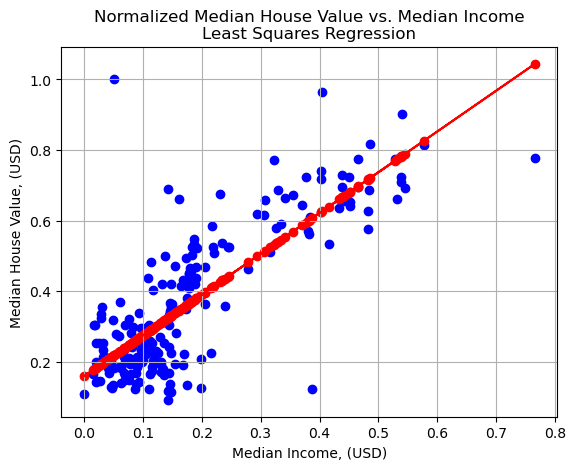

In [11]:
x_fit = X_train
y_fit = theta_0 + theta_1*X_train

plt.scatter(X_train,y_train, color='blue')
plt.scatter(x_fit, y_fit, color='red')
plt.plot(x_fit, y_fit, color='red')
plt.title('Normalized Median House Value vs. Median Income\nLeast Squares Regression')
plt.xlabel('Median Income, (USD)')
plt.ylabel('Median House Value, (USD)')
plt.grid(True)
plt.show()

Our line fits the normalized data nicely. Our next task is to convert $\Theta_0$ and $\Theta_1$ to reflect the raw data. 

In [12]:
def unscale_theta(theta_0, theta_1, scaler):
    x_min = scaler.data_min_[0]  # for median_income
    x_max = scaler.data_max_[0]
    y_min = scaler.data_min_[1]  # for median_house_value
    y_max = scaler.data_max_[1]

    theta_1_raw = theta_1 * (y_max - y_min) / (x_max - x_min)
    theta_0_raw = y_min + (y_max - y_min) * theta_0 - theta_1_raw * x_min

    return theta_0_raw, theta_1_raw

In [13]:
theta_0_raw, theta_1_raw = unscale_theta(theta_0, theta_1, scaler)

Let's estimate the price of a home for a median income of say, $110,000.

In [14]:
X_spot = 11.1 #expressed in tens of thousands of dollars
pred = theta_0_raw + theta_1_raw * X_spot
print('The estimated house price is, $%s'%round(pred,0))

The estimated house price is, $501896.0


<h3>Conclusion</h3>
We have walked through a simple example of Least Squares Regression, observing how we are seeking a global minimum of a surface. In practice, this can be applied to more than one feature (e.g., we may want to include number of bedrooms, square footage, etc.). In such a case, the sheet still will have a global minimum, but we won't be able to envisage this multi-dimensional space. Moreover, for such a multi-feature hypotheses, it is in our best interest to convert our notation to matricies. That will be left for another notebook, as will the situtation where we have to deal with such a large dataset that Gradient Descent is no longer computationally affordable. 

<h3>References</h3>

Géron, A. (2019). Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow: Concepts, Tools, and Techniques to Build Intelligent Systems (2nd ed.). O'Reilly Media.